In [30]:
import os
import cv2
from PIL import Image, ImageOps, ImageFilter
import numpy as np
from IPython.display import display
import random
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [31]:
base_path = "/Users/nitesh/Downloads/test_images/"
image_paths = os.listdir(base_path)
print(len(image_paths))

1003


In [32]:
label_map = {1: "ticker", 0:"no_ticker"}

labels = []
pos = 0
neg = 0
total = len(image_paths)
for _path in image_paths:
    if _path.startswith("ticker_"):
        pos += 1
        labels.append(1)
    elif _path.startswith("no_ticker_"):
        neg += 1
        labels.append(0)

print((pos/total)*100, (neg/total)*100)

74.17746759720838 25.822532402791627


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.10, random_state=42, stratify=labels
)

train_data = []
for _path, label in zip(X_train, y_train):
    obj = {"path": os.path.join(base_path, _path), "label": label_map.get(label)}
    train_data.append(obj)

test_data = []
for _path, label in zip(X_test, y_test):
    obj = {"path": os.path.join(base_path, _path), "label": label_map.get(label)}
    test_data.append(obj)

print(len(train_data), len(test_data))

902 101


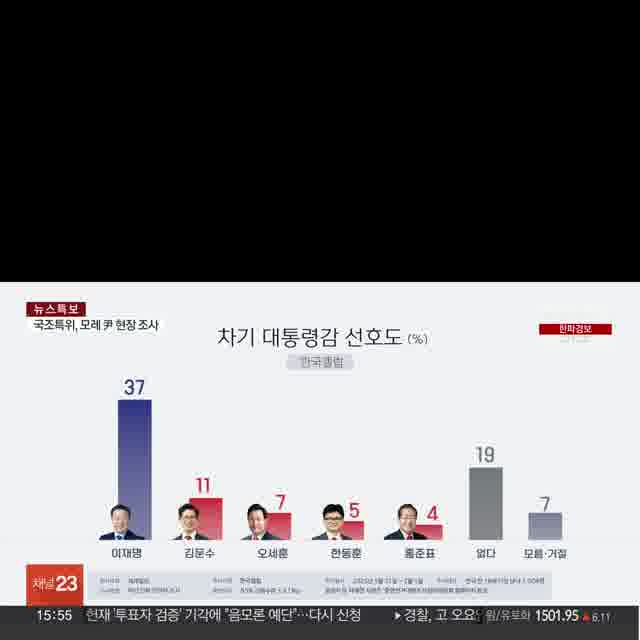

In [34]:
## Example: With ticker
Image.open(train_data[0]['path'])

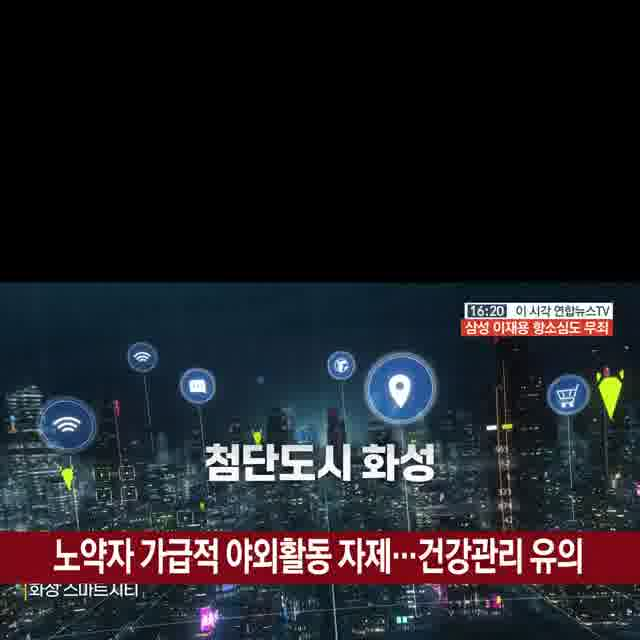

In [35]:
## Example: No-ticker
Image.open(train_data[-2]['path'])

## Baseline

In [36]:
## Utility function
def zoom_at(img, zoom=1, angle=0, coord=None):

    cy, cx = [i / 2 for i in img.shape] if coord is None else coord[::-1]

    rot_mat = cv2.getRotationMatrix2D((cx, cy), angle, zoom)
    result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    return result

### Using Horizontal Projection Profile

In [ ]:

def detect_ticker_with_density(image_path, visualize=False):
    """
    Detects whether a ticker is present at the bottom of the image.

    Parameters:
    - image_path (str): Path to the input image.
    - visualize (bool): Whether to display intermediate processing steps.

    Returns:
    - (bool): True if a ticker is detected, False otherwise.
    """

    # Load Image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found!")

    # Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Crop the bottom 8-10% (Focus on ticker region)
    h, w = gray.shape
    ticker_roi = gray[int(h * 0.92) :, :]
    
    # # Zoom into the cropped region (e.g., 2x zoom)
    # zoom_factor = 2
    # zoomed_ticker_roi = zoom_at(ticker_roi, zoom=zoom_factor)

    # Apply Canny Edge Detection
    edges = cv2.Canny(ticker_roi, 50, 150)

    # # Approach: Using Projection profile
    # Compute Horizontal Projection Profile
    projection = np.sum(edges, axis=1)

    # Find the row with highest intensity (potential ticker row)
    max_intensity_row = np.argmax(projection)

    # Visualization (if enabled)
    if visualize:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(edges, cmap='gray')
        plt.title("Edge Detected Image")

        plt.subplot(1, 2, 2)
        plt.plot(projection)
        plt.axvline(max_intensity_row, color='red', linestyle='dashed', label='Max Edge Density Row')
        plt.title("Horizontal Projection Profile")
        plt.xlabel("Row Index")
        plt.ylabel("Edge Density")
        plt.legend()
        plt.show()

    return max_intensity_row > int(0.2 * ticker_roi.shape[0])

for idx, obj in enumerate(train_data):
    image_path = obj["path"]
    result = detect_ticker_with_density(image_path, visualize=False)
    print(f"Image: {image_path} | Ticker Detected: {result} | Label: {obj['label']}")
    obj["pred"] = int(result)

In [38]:
true_labels = np.array(
    [int(obj["label"] == "ticker") for obj in train_data]
)
pred_labels = np.array([int(obj["pred"]) for obj in train_data])
print(confusion_matrix(y_true=true_labels, y_pred=pred_labels))
print(classification_report(y_true=true_labels, y_pred=pred_labels))

[[ 54 179]
 [  0 669]]
              precision    recall  f1-score   support

           0       1.00      0.23      0.38       233
           1       0.79      1.00      0.88       669

    accuracy                           0.80       902
   macro avg       0.89      0.62      0.63       902
weighted avg       0.84      0.80      0.75       902



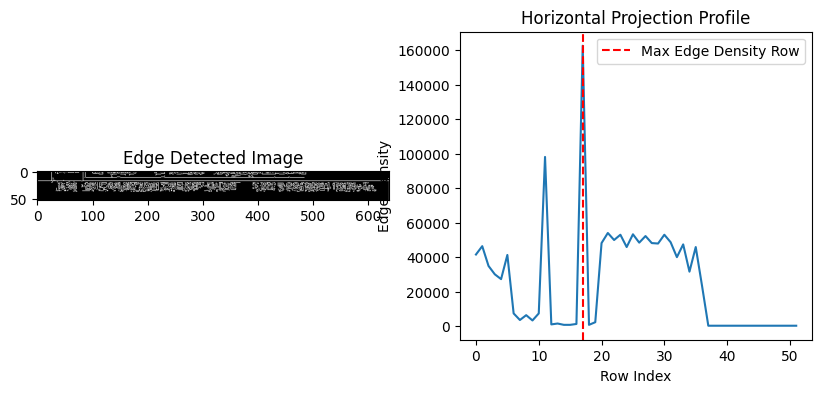

Image: /Users/nitesh/Downloads/test_images/ticker_06830.jpg | Ticker Detected: True | Label: ticker


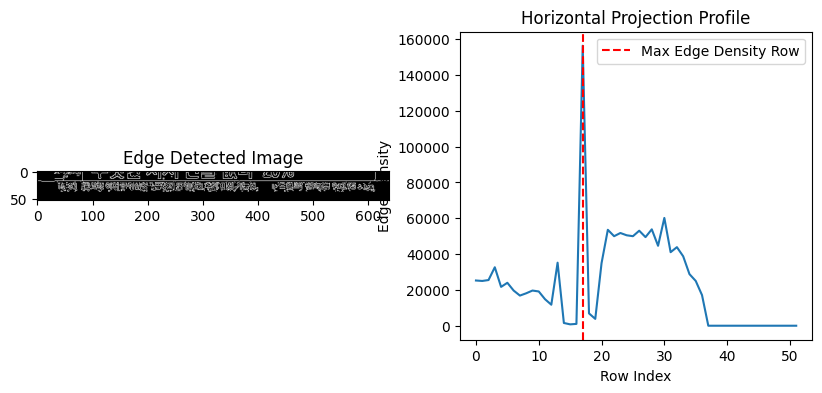

Image: /Users/nitesh/Downloads/test_images/ticker_06376.jpg | Ticker Detected: True | Label: ticker


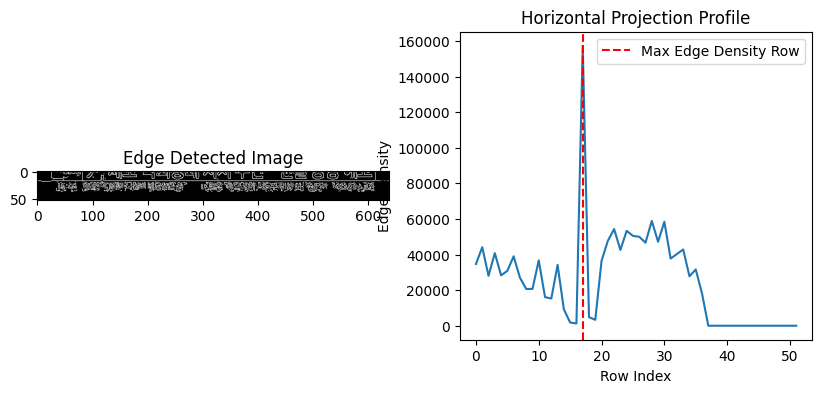

Image: /Users/nitesh/Downloads/test_images/ticker_03549.jpg | Ticker Detected: True | Label: ticker


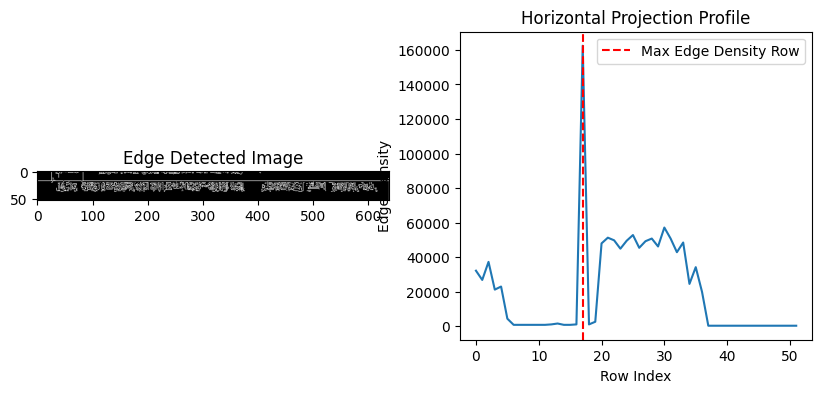

Image: /Users/nitesh/Downloads/test_images/ticker_01474.jpg | Ticker Detected: True | Label: ticker


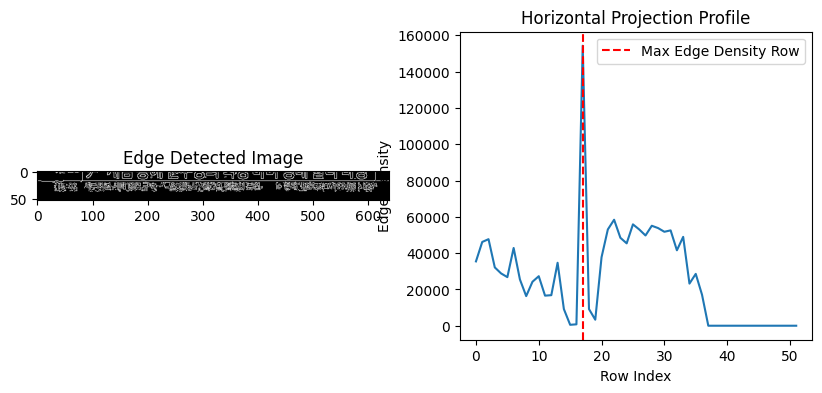

Image: /Users/nitesh/Downloads/test_images/ticker_04403.jpg | Ticker Detected: True | Label: ticker


In [39]:
count = 0
for idx, obj in enumerate(train_data):
    image_path = obj["path"]
    if obj['label'] == "ticker":
        result = detect_ticker_with_density(image_path, visualize=True)
        print(f"Image: {image_path} | Ticker Detected: {result} | Label: {obj['label']}")
        obj["pred"] = int(result)
        count += 1
    if count >= 5: break

**Note - So many False-Positives, not a desirable solution**

### Using Contour Detection with thresholding

In [ ]:
def detect_ticker_with_contour(image_path, visualize=False):
    """
    Detects whether a ticker is present at the bottom of the image.

    Parameters:
    - image_path (str): Path to the input image.
    - visualize (bool): Whether to display intermediate processing steps.

    Returns:
    - (bool): True if a ticker is detected, False otherwise.
    """

    # Load Image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found!")

    # Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Crop the bottom 8-10% (Focus on ticker region)
    h, w = gray.shape
    ticker_roi = gray[int(h * 0.92) :, :]

    # Zoom into the cropped region (e.g., 2x zoom)
    zoom_factor = 2
    zoomed_ticker_roi = zoom_at(ticker_roi, zoom=zoom_factor)
    
    # Apply Binary Threshold
    ret, im = cv2.threshold(zoomed_ticker_roi, 100, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detected = False
    contour_img = cv2.cvtColor(zoomed_ticker_roi, cv2.COLOR_GRAY2BGR)

    # Create a mask to check for overlapping contours
    mask = np.zeros_like(im)
    non_overlapping_contours = 0
    aspect_ratios = []
    # Filter contours by shape (Wide & Short structures)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h

        # Check if the contour overlaps with any existing contours in the mask
        contour_mask = np.zeros_like(im)
        cv2.drawContours(contour_mask, [cnt], -1, 255, -1)
        if np.any(cv2.bitwise_and(mask, contour_mask)):
            continue  # Skip overlapping contours

        cv2.drawContours(mask, [cnt], -1, 255, -1)
        non_overlapping_contours += 1
        aspect_ratios.append(aspect_ratio)
        cv2.rectangle(contour_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Ticker is a continuos sequence of almost square contours, mostly non-overlapping
    # Value ranges are taken using the analysis plots below.
    if (20 <= non_overlapping_contours <= 60
        and 0.8 < np.median(aspect_ratios) < 1.6
    ):
        detected = True
    # Visualization (if enabled)
    if visualize:
        steps = [
            ("Cropped ROI", ticker_roi),
            ("Zoomed ROI", zoomed_ticker_roi),
            ("Binarized", im),
            ("Contour Detection", contour_img),
        ]

        fig, axs = plt.subplots(1, len(steps), figsize=(20, 5))
        for ax, (title, img) in zip(axs, steps):
            cmap = "gray" if len(img.shape) == 2 else None
            ax.imshow(img, cmap=cmap)
            ax.set_title(title)
            ax.axis("off")
        plt.show()

    return (
        detected,
        non_overlapping_contours,
        np.mean(aspect_ratios),
        np.median(aspect_ratios),
    )


non_overlapping_contours_count = []
mean_aspect_ratios = []
median_aspect_ratios = []
for idx, obj in enumerate(train_data):
    image_path = obj["path"]
    result, non_overlapping_contours, mean_aspect_ratio, median_aspect_ratio = (
        detect_ticker_with_contour(image_path, visualize=False)
    )
    print(f"Image: {image_path} | Ticker Detected: {result} | Label: {obj['label']}")
    obj["pred"] = int(result)
    non_overlapping_contours_count.append((non_overlapping_contours, obj["label"]))
    mean_aspect_ratios.append((mean_aspect_ratio, obj["label"]))
    median_aspect_ratios.append((median_aspect_ratio, obj["label"]))

In [41]:
true_labels = np.array(
    [int(obj["label"] == "ticker") for obj in train_data]
)
pred_labels = np.array([int(obj["pred"]) for obj in train_data])
print(confusion_matrix(y_true=true_labels, y_pred=pred_labels))
print(classification_report(y_true=true_labels, y_pred=pred_labels))

[[218  15]
 [  4 665]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       233
           1       0.98      0.99      0.99       669

    accuracy                           0.98       902
   macro avg       0.98      0.96      0.97       902
weighted avg       0.98      0.98      0.98       902



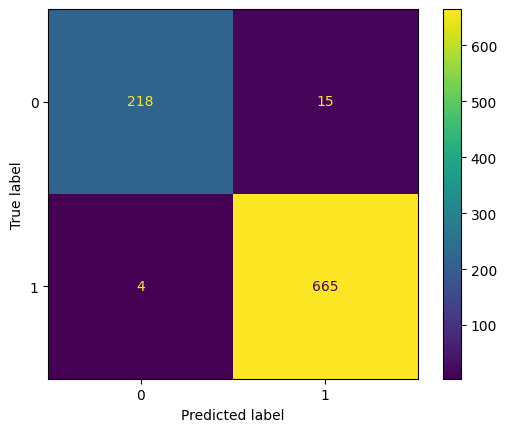

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=true_labels, y_pred=pred_labels),
                              display_labels=[0, 1])
disp.plot()
plt.show()

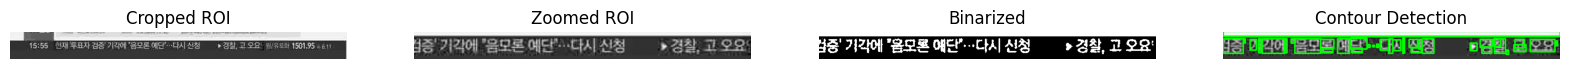

Image: /Users/nitesh/Downloads/test_images/ticker_06830.jpg | Ticker Detected: True | Label: ticker


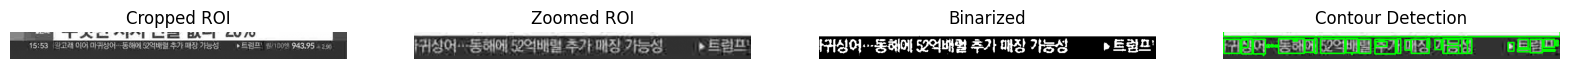

Image: /Users/nitesh/Downloads/test_images/ticker_06376.jpg | Ticker Detected: True | Label: ticker


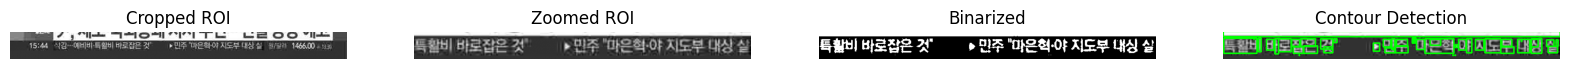

Image: /Users/nitesh/Downloads/test_images/ticker_03549.jpg | Ticker Detected: True | Label: ticker


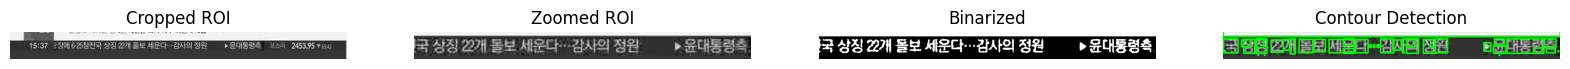

Image: /Users/nitesh/Downloads/test_images/ticker_01474.jpg | Ticker Detected: True | Label: ticker


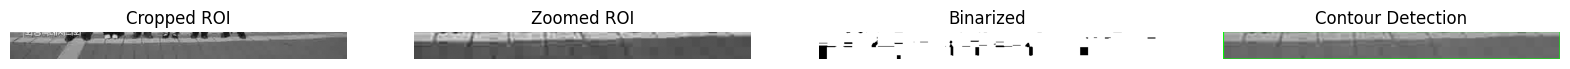

Image: /Users/nitesh/Downloads/test_images/no_ticker_01145.jpg | Ticker Detected: False | Label: no_ticker


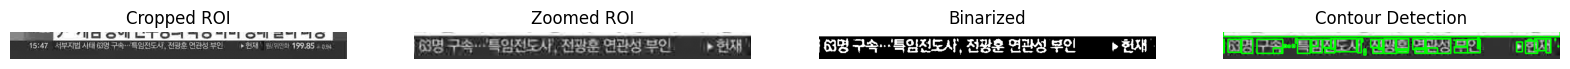

Image: /Users/nitesh/Downloads/test_images/ticker_04403.jpg | Ticker Detected: True | Label: ticker


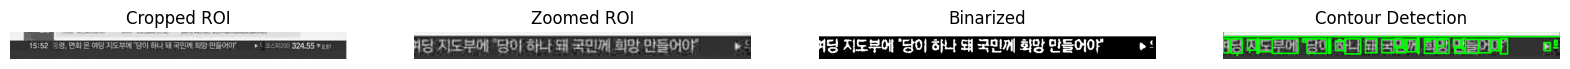

Image: /Users/nitesh/Downloads/test_images/ticker_06116.jpg | Ticker Detected: True | Label: ticker


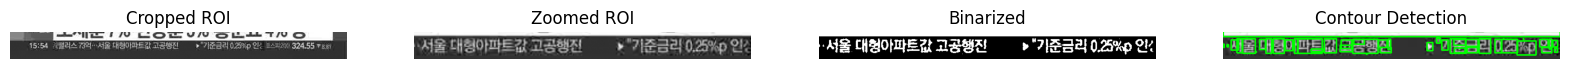

Image: /Users/nitesh/Downloads/test_images/ticker_06522.jpg | Ticker Detected: True | Label: ticker


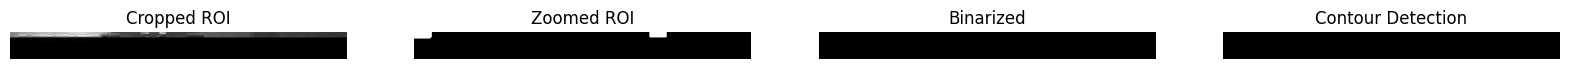

Image: /Users/nitesh/Downloads/test_images/no_ticker_00520.jpg | Ticker Detected: False | Label: no_ticker


/Users/nitesh/envs/process_img_env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nitesh/envs/process_img_env/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


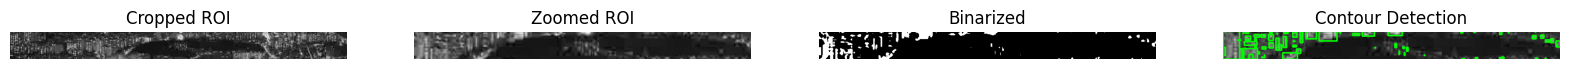

Image: /Users/nitesh/Downloads/test_images/no_ticker_00818.jpg | Ticker Detected: False | Label: no_ticker


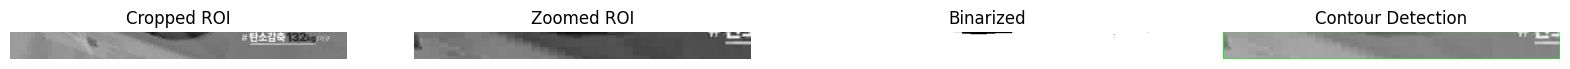

Image: /Users/nitesh/Downloads/test_images/no_ticker_02169.jpg | Ticker Detected: False | Label: no_ticker


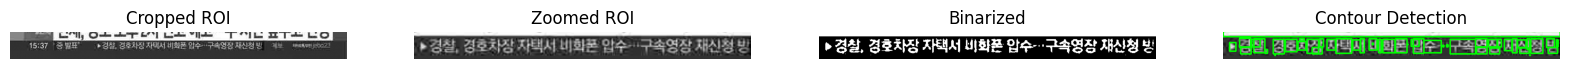

Image: /Users/nitesh/Downloads/test_images/ticker_01657.jpg | Ticker Detected: True | Label: ticker


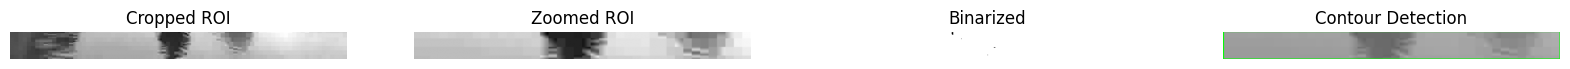

Image: /Users/nitesh/Downloads/test_images/no_ticker_00369.jpg | Ticker Detected: False | Label: no_ticker


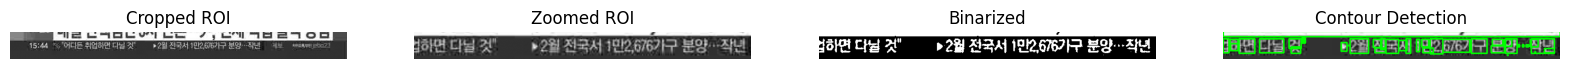

Image: /Users/nitesh/Downloads/test_images/ticker_03639.jpg | Ticker Detected: True | Label: ticker


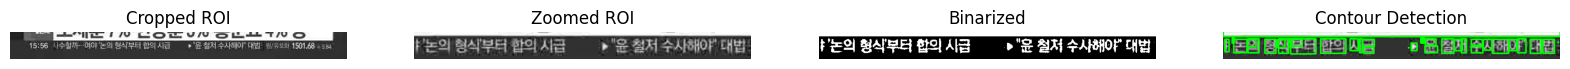

Image: /Users/nitesh/Downloads/test_images/ticker_07221.jpg | Ticker Detected: True | Label: ticker


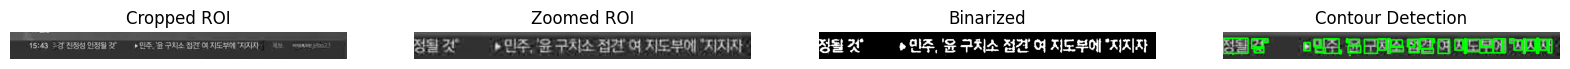

Image: /Users/nitesh/Downloads/test_images/ticker_03238.jpg | Ticker Detected: True | Label: ticker


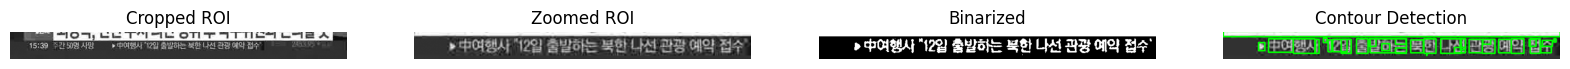

Image: /Users/nitesh/Downloads/test_images/ticker_02261.jpg | Ticker Detected: True | Label: ticker


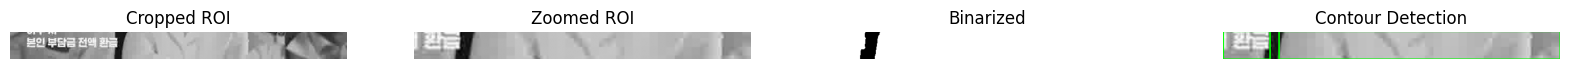

Image: /Users/nitesh/Downloads/test_images/no_ticker_01895.jpg | Ticker Detected: False | Label: no_ticker


In [21]:
ticker_count = 0
no_ticker_count = 0
for idx, obj in enumerate(train_data):
    image_path = obj["path"]
    if obj["label"] == "ticker":
        result = detect_ticker_with_contour(image_path, visualize=True)[0]
        print(
            f"Image: {image_path} | Ticker Detected: {result} | Label: {obj['label']}"
        )
        obj["pred"] = int(result)
        ticker_count += 1
    elif obj["label"] == "no_ticker":
        result = detect_ticker_with_contour(image_path, visualize=True)[0]
        print(
            f"Image: {image_path} | Ticker Detected: {result} | Label: {obj['label']}"
        )
        obj["pred"] = int(result)
        no_ticker_count += 1
    if ticker_count >= 5 and no_ticker_count > 5:
        break

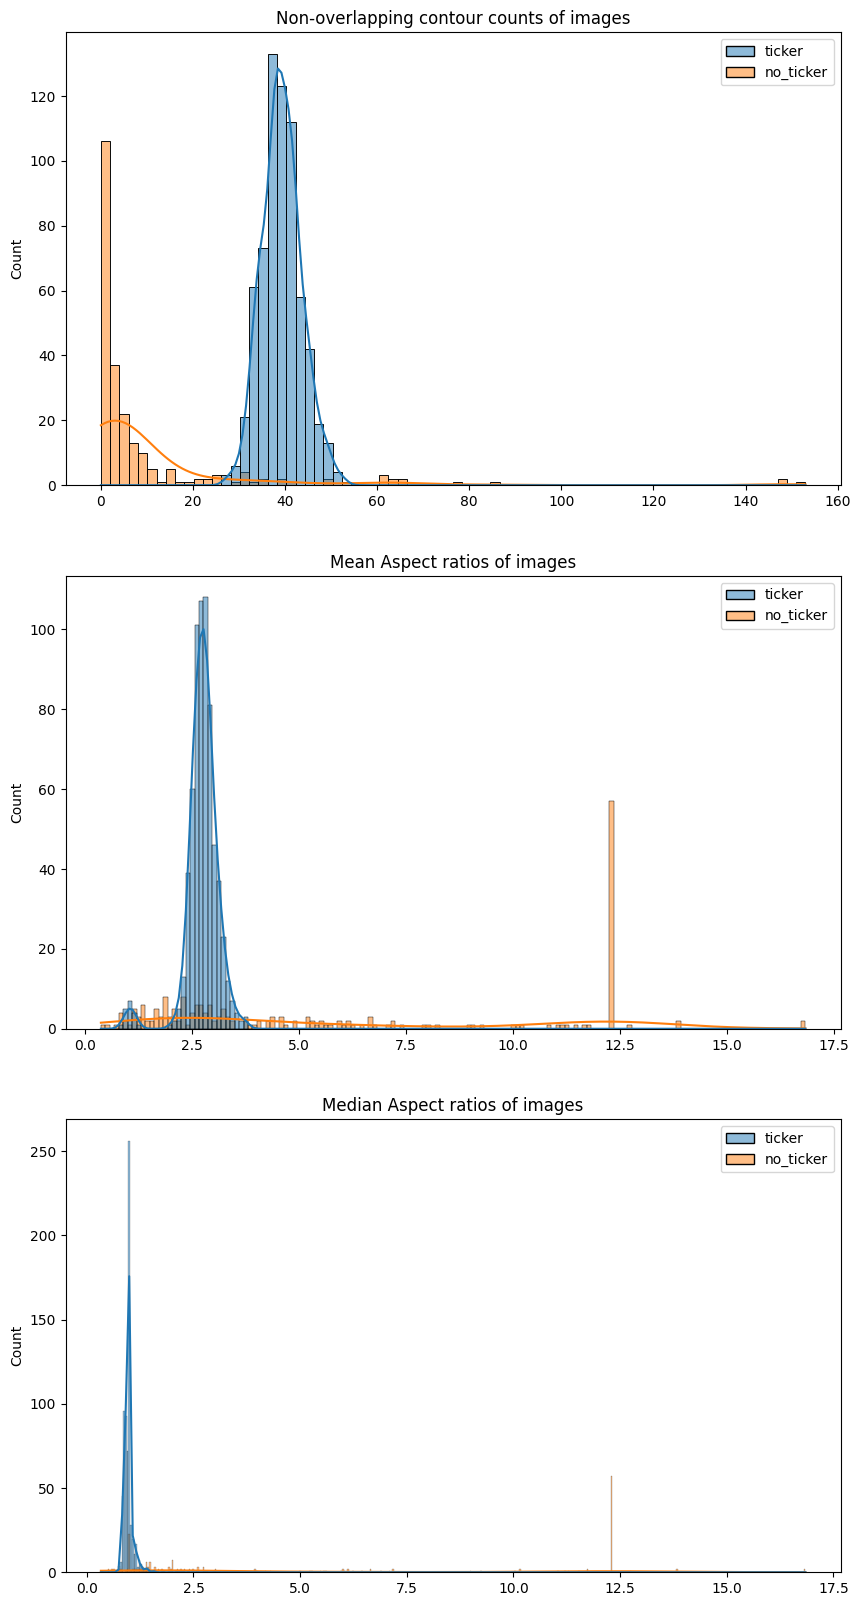

In [22]:
import seaborn as sns

fig, axes = plt.subplots(3,1, figsize = (10, 20))
sns.histplot(
    x=[obj[0] for obj in non_overlapping_contours_count],
    hue=[obj[1] for obj in non_overlapping_contours_count],
    kde=True,
    ax=axes[0]
)
axes[0].set_title("Non-overlapping contour counts of images")
sns.histplot(
    x=[obj[0] for obj in mean_aspect_ratios],
    hue=[obj[1] for obj in mean_aspect_ratios],
    kde=True,
    ax=axes[1]
)
axes[1].set_title("Mean Aspect ratios of images")
sns.histplot(
    x=[obj[0] for obj in median_aspect_ratios],
    hue=[obj[1] for obj in median_aspect_ratios],
    kde=True,
    ax=axes[2]
)
axes[2].set_title("Median Aspect ratios of images")
plt.show()

### Testing on hold-out samples

In [ ]:
for idx, obj in enumerate(test_data):
    image_path = obj["path"]
    result, non_overlapping_contours, mean_aspect_ratio, median_aspect_ratio = (
        detect_ticker_with_contour(image_path, visualize=False)
    )
    print(f"Image: {image_path} | Ticker Detected: {result} | Label: {obj['label']}")
    obj["pred"] = int(result)

In [24]:
true_labels = np.array(
    [int(obj["label"] == "ticker") for obj in test_data]
)
pred_labels = np.array([int(obj["pred"]) for obj in test_data])
print(confusion_matrix(y_true=true_labels, y_pred=pred_labels))
print(classification_report(y_true=true_labels, y_pred=pred_labels))

[[25  1]
 [ 2 73]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        26
           1       0.99      0.97      0.98        75

    accuracy                           0.97       101
   macro avg       0.96      0.97      0.96       101
weighted avg       0.97      0.97      0.97       101



**Note -  We can also put a check on number of non-overlapping contours to strengthen our prediction**

## Testing With Augmentation

In [ ]:
augmented_data = []


def get_augmentations(img_path):
    # Read the image
    img = Image.open(img_path)

    # 1. GrayScale
    img_gray = ImageOps.grayscale(img)
    # 2. Vertical Flip
    img_flip = ImageOps.mirror(img_gray)
    # 3. Blur
    img_blur = img_flip.filter(ImageFilter.GaussianBlur(radius=1))
    # # 4. Add noise
    # img_array = np.array(img_blur)
    # noise = np.random.normal(0, 25, img_array.shape).astype(np.uint8)
    # img_noisy = Image.fromarray(np.clip(img_array + noise, 0, 255).astype(np.uint8))

    # Save the resultant augmented image
    base_path, img_path = img_path.rsplit("/", 1)
    base_path_new = base_path+ "_augmented"
    os.makedirs(base_path_new, exist_ok=True)

    output_path = os.path.join(base_path_new, f"{img_path.split('.')[0]}.jpg")
    img_blur.save(output_path)

    return output_path

non_overlapping_contours_count_test = []
mean_aspect_ratios_test = []
median_aspect_ratios_test = []
for obj in test_data:
    augmented_image_path = get_augmentations(obj["path"])
    new_obj = {"path": augmented_image_path, "label": obj["label"]}
    result, non_overlapping_contours, mean_aspect_ratio, median_aspect_ratio = (
        detect_ticker_with_contour(augmented_image_path, visualize=False)
    )
    print(f"Image: {augmented_image_path} | Ticker Detected: {result} | Label: {obj['label']}")
    new_obj["pred"] = int(result)
    augmented_data.append(new_obj)
    non_overlapping_contours_count_test.append((non_overlapping_contours, obj["label"]))
    mean_aspect_ratios_test.append((mean_aspect_ratio, obj["label"]))
    median_aspect_ratios_test.append((median_aspect_ratio, obj["label"]))

In [26]:
true_labels = np.array(
    [int(obj["label"] == "ticker") for obj in augmented_data]
)
pred_labels = np.array([int(obj["pred"]) for obj in augmented_data])
print(confusion_matrix(y_true=true_labels, y_pred=pred_labels))
print(classification_report(y_true=true_labels, y_pred=pred_labels))

[[26  0]
 [ 0 75]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        75

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101



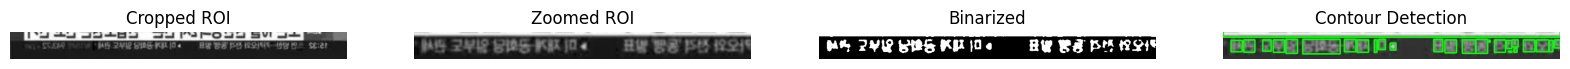

Image: /Users/nitesh/Downloads/test_images_augmented/ticker_00161.jpg | Ticker Detected: True | Label: ticker


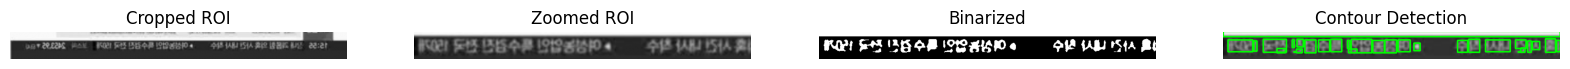

Image: /Users/nitesh/Downloads/test_images_augmented/ticker_06881.jpg | Ticker Detected: True | Label: ticker


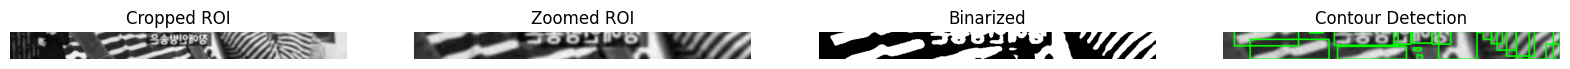

Image: /Users/nitesh/Downloads/test_images_augmented/no_ticker_02071.jpg | Ticker Detected: False | Label: no_ticker


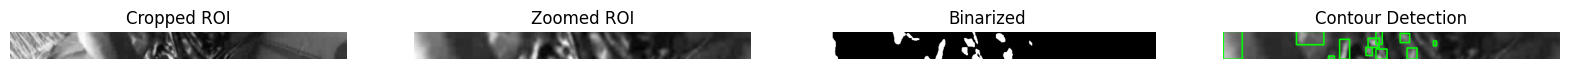

Image: /Users/nitesh/Downloads/test_images_augmented/no_ticker_00660.jpg | Ticker Detected: False | Label: no_ticker


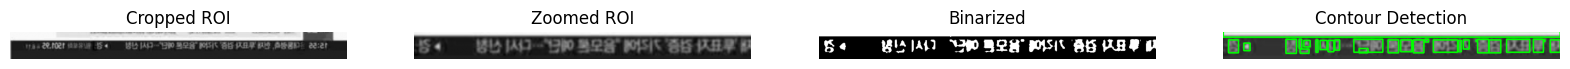

Image: /Users/nitesh/Downloads/test_images_augmented/ticker_06823.jpg | Ticker Detected: True | Label: ticker


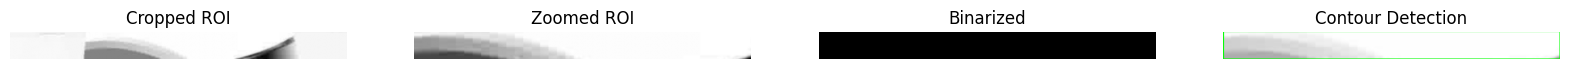

Image: /Users/nitesh/Downloads/test_images_augmented/no_ticker_01680.jpg | Ticker Detected: False | Label: no_ticker


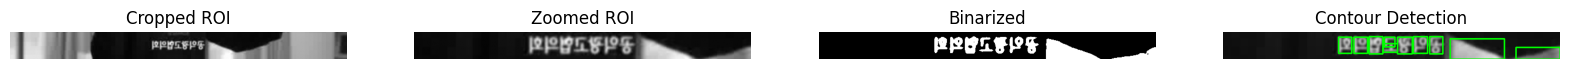

Image: /Users/nitesh/Downloads/test_images_augmented/no_ticker_02187.jpg | Ticker Detected: False | Label: no_ticker


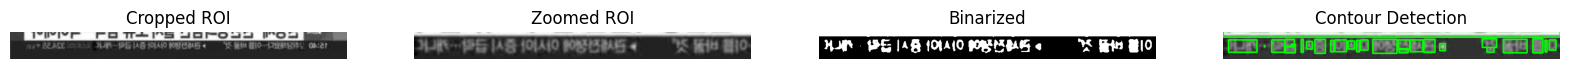

Image: /Users/nitesh/Downloads/test_images_augmented/ticker_02512.jpg | Ticker Detected: True | Label: ticker


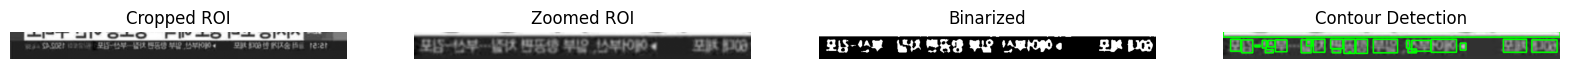

Image: /Users/nitesh/Downloads/test_images_augmented/ticker_05613.jpg | Ticker Detected: True | Label: ticker


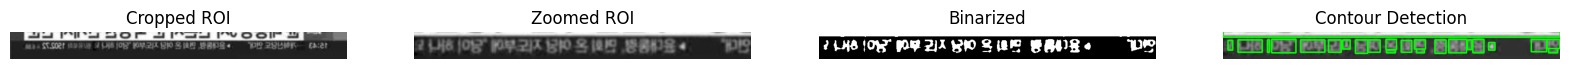

Image: /Users/nitesh/Downloads/test_images_augmented/ticker_03422.jpg | Ticker Detected: True | Label: ticker


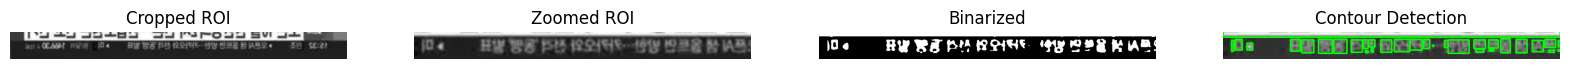

Image: /Users/nitesh/Downloads/test_images_augmented/ticker_00145.jpg | Ticker Detected: True | Label: ticker


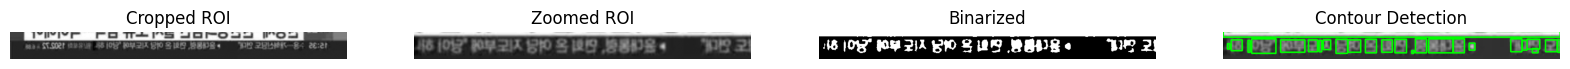

Image: /Users/nitesh/Downloads/test_images_augmented/ticker_00825.jpg | Ticker Detected: True | Label: ticker


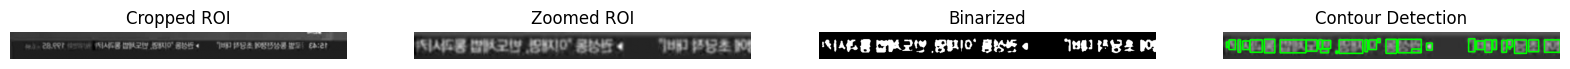

Image: /Users/nitesh/Downloads/test_images_augmented/ticker_03187.jpg | Ticker Detected: True | Label: ticker


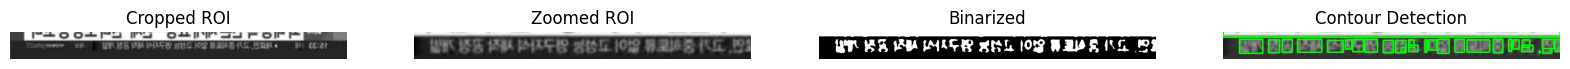

Image: /Users/nitesh/Downloads/test_images_augmented/ticker_00441.jpg | Ticker Detected: True | Label: ticker


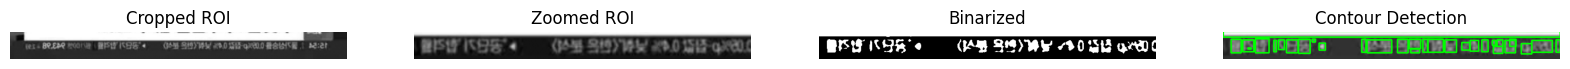

Image: /Users/nitesh/Downloads/test_images_augmented/ticker_06569.jpg | Ticker Detected: True | Label: ticker


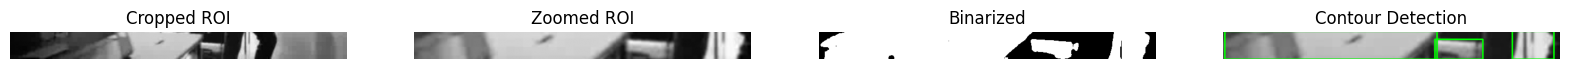

Image: /Users/nitesh/Downloads/test_images_augmented/no_ticker_00295.jpg | Ticker Detected: False | Label: no_ticker


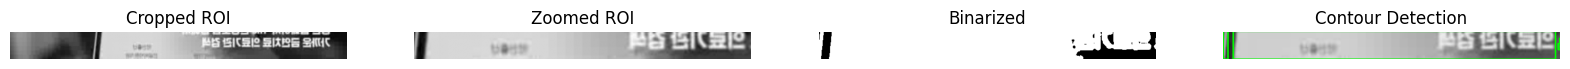

Image: /Users/nitesh/Downloads/test_images_augmented/no_ticker_01877.jpg | Ticker Detected: False | Label: no_ticker


In [27]:
ticker_count = 0
no_ticker_count = 0
for idx, obj in enumerate(augmented_data):
    image_path = obj["path"]
    if obj['label'] == "ticker":
        result = detect_ticker_with_contour(image_path, visualize=True)[0]
        print(f"Image: {image_path} | Ticker Detected: {result} | Label: {obj['label']}")
        obj["pred"] = int(result)
        ticker_count += 1
    elif obj['label'] == "no_ticker":
        result = detect_ticker_with_contour(image_path, visualize=True)[0]
        print(f"Image: {image_path} | Ticker Detected: {result} | Label: {obj['label']}")
        obj["pred"] = int(result)
        no_ticker_count += 1
    if ticker_count >= 5 and no_ticker_count > 5: break

**Note- Detecting ticker with help of contours shows promising results on augmented images as well, depicting robustness.**

In [28]:
# fig, axes = plt.subplots(3,1, figsize = (10, 20))
# sns.histplot(
#     x=[obj[0] for obj in non_overlapping_contours_count_test],
#     hue=[obj[1] for obj in non_overlapping_contours_count_test],
#     kde=True,
#     ax=axes[0]
# )
# axes[0].set_title("Non-overlapping contour counts of images")
# sns.histplot(
#     x=[obj[0] for obj in mean_aspect_ratios_test],
#     hue=[obj[1] for obj in mean_aspect_ratios_test],
#     kde=True,
#     ax=axes[1]
# )
# axes[1].set_title("Mean Aspect ratios of images")
# sns.histplot(
#     x=[obj[0] for obj in median_aspect_ratios_test],
#     hue=[obj[1] for obj in median_aspect_ratios_test],
#     kde=True,
#     ax=axes[2]
# )
# axes[2].set_title("Median Aspect ratios of images")
# plt.show()